<a href="https://colab.research.google.com/github/Rubnserrano/TF-Certification/blob/main/04_curso_tensorflow_certificate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#04. Transfer Learning With Tensorflow PART1: Feature Extraction

In [1]:
!nvidia-smi


Tue Nov  1 23:41:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    16W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##TensorFlow Hub is a repository for existing model components. You can import and use a fully trained model.
## Transfer learning often allows you to get great results with less data.



In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2022-11-01 23:41:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   153MB/s    in 1.1s    

2022-11-01 23:41:43 (153 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 10 director

## Creating data loaders

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')
print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


#Setting up callbacks (things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
- Experiment tracking with TensorBoard (compare these models in a visual way on TensorBoard) Helpful to compare results of different models on your data
- Model checkpointing (stop training if needed and come back to continue off where u left)
- Early stopping 

In [5]:
# To track our modelling experiments using TensorBoard, lets create a function which creates a TensorBoard callback for us

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

#Our function saves a model's performance logs to a directory named dir_name/experiment_name/current_timestamp

##Copy url of tensorhub: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

## - Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
##- Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model. 

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
#resnet 50 v2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

#original: efficientnetb0 feature vector (version1)
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

#new efficientnetb0 feature vector (version2)
# efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False,
                                          name='feature_extraction_layer',
                                          input_shape = IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])
  return model

In [9]:
#Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

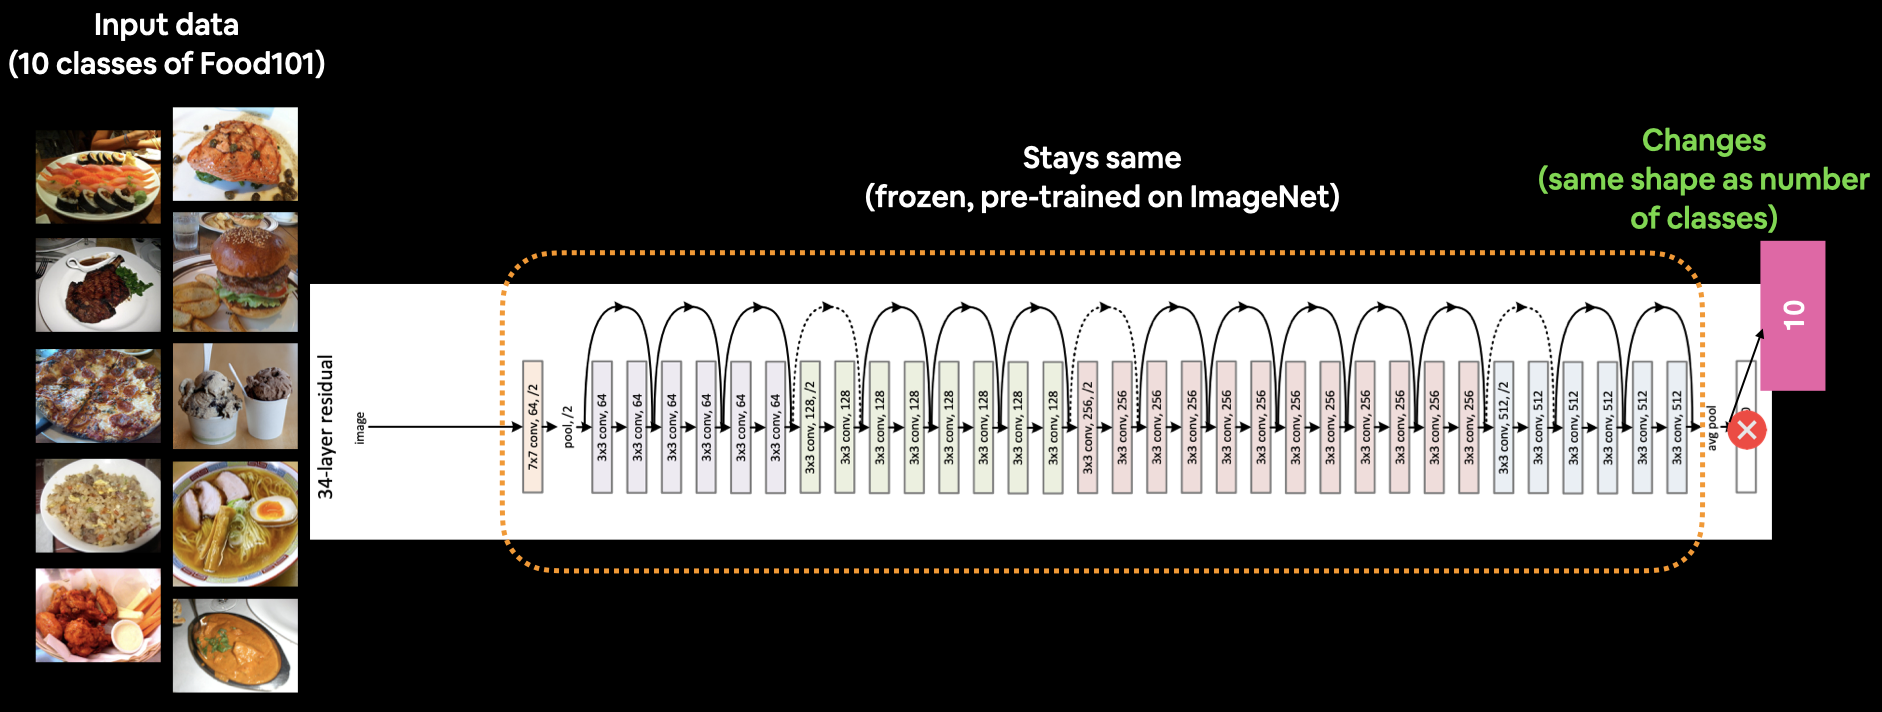

## Before we call the fit function we're going to add a callback. A tensorboard callback so we can track the performance of our model on TensorBoard.

In [10]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                           experiment_name = 'resnet50V2')])

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20221101-234219
Epoch 1/5
24/24 [==============================] - 24s 762ms/step - loss: 2.1096 - accuracy: 0.3253 - val_loss: 1.3147 - val_accuracy: 0.6016
Epoch 2/5
24/24 [==============================] - 16s 701ms/step - loss: 0.9729 - accuracy: 0.7227 - val_loss: 0.8837 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 16s 679ms/step - loss: 0.6597 - accuracy: 0.8040 - val_loss: 0.7963 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 16s 672ms/step - loss: 0.5098 - accuracy: 0.8613 - val_loss: 0.7226 - val_accuracy: 0.7600
Epoch 5/5
24/24 [==============================] - 16s 700ms/step - loss: 0.4095 - accuracy: 0.8960 - val_loss: 0.6779 - val_accuracy: 0.7816


In [11]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

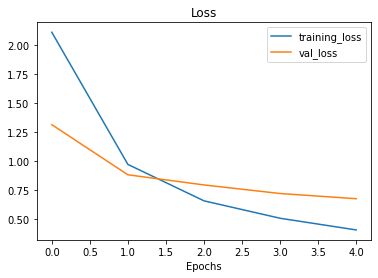

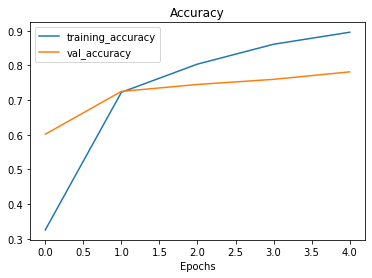

In [12]:
plot_loss_curves(resnet_history)

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
#the same with efficientnet
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data_10_percent,
                                              validation_steps = len(test_data_10_percent),
                                              callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                       experiment_name = 'efficientnetb0')])

Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20221101-234418
Epoch 1/5
24/24 [==============================] - 26s 714ms/step - loss: 1.8786 - accuracy: 0.4373 - val_loss: 1.3352 - val_accuracy: 0.7168
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 1.0736 - accuracy: 0.7880 - val_loss: 0.8874 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 15s 643ms/step - loss: 0.7643 - accuracy: 0.8360 - val_loss: 0.7102 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 15s 640ms/step - loss: 0.6105 - accuracy: 0.8773 - val_loss: 0.6190 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 15s 644ms/step - loss: 0.5180 - accuracy: 0.8880 - val_loss: 0.5647 - val_accuracy: 0.8624


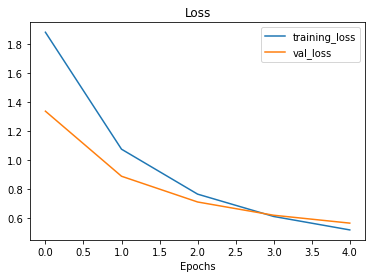

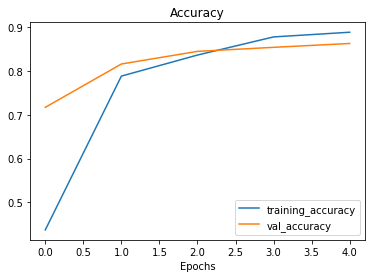

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


##Comparing models using TensorBoard

In [17]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/sklzyqzJT2SzF8rYYViecQ/

[2022-11-01T23:46:26] Started scanning logdir.
[2022-11-01T23:46:32] Total uploaded: 162 scalars, 0 tensors, 6 binary objects (15.6 MB)
[2022-11-01T23:46:32] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/sklzyqzJT2SzF8rYYViecQ/


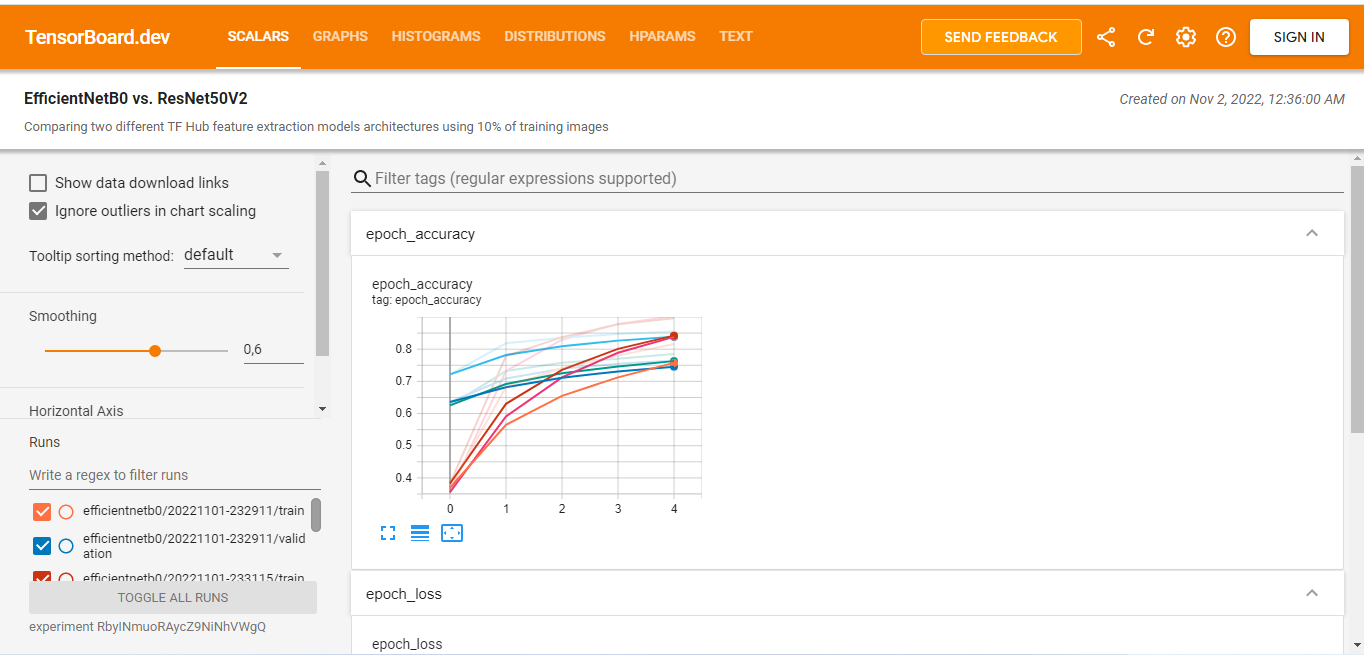

In [18]:
!tensorboard dev list

https://tensorboard.dev/experiment/sklzyqzJT2SzF8rYYViecQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   sklzyqzJT2SzF8rYYViecQ
	Created              2022-11-01 23:46:26 (42 seconds ago)
	Updated              2022-11-01 23:46:32 (36 seconds ago)
	Runs                 12
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  16336250
Total: 1 experiment(s)


#Deleting experiments from TensorBoard

In [19]:
!tensorboard dev delete --experiment_id sklzyqzJT2SzF8rYYViecQ

Deleted experiment sklzyqzJT2SzF8rYYViecQ.


In [20]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
